# Fastjet Example
Use [fastjet](https://github.com/scikit-hep/fastjet) to cluster jets in python. This example uses the [LHC Olympics dataset](https://lhco2020.github.io/homepage/).

## Imports

In [42]:
import fastjet as fj
import energyflow as ef
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
from cycler import cycler
import awkward as ak
import vector
import h5py

In [2]:
# Define plot style
mpl.rcParams["axes.prop_cycle"] = cycler(
    color=[
        "#B6BFC3",
        "#3B515B",
        "#0271BB",
        "#E2001A",
    ]
)
mpl.rcParams["font.size"] = 15
mpl.rcParams["patch.linewidth"] = 1.25

## Load Data 

In [3]:
filepath = "/beegfs/desy/user/ewencedr/data/lhco/events_anomalydetection_v2.h5"

In [4]:
# Load everything into memory
df = pd.read_hdf(filepath)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3))

(1100000, 2101)
Memory in GB: 17.227232456207275


In [5]:
# split data into signal and background
np_array = np.array(df)
background = np_array[np_array[:,2100]==0] 
signal = np_array[np_array[:,2100]==1]

In [6]:
# change the shape of the data to (n_events, n_particles, n_features) and remove the singal/background label
qcd_data = background[:, :2100].reshape(-1, 700, 3)
sig_data = signal[:, :2100].reshape(-1, 700, 3)

In [36]:
# save lengths of signal and background data for later use
len_bckg = len(qcd_data)
len_sig = len(sig_data)
print(f"Background events: {len_bckg}")
print(f"Signal events: {len_sig}")

Background events: 1000000
Signal events: 100000


In [7]:
data_full = np.concatenate((qcd_data, sig_data), axis=0)

Let's look at the data. We have 1.000.000 background events and 100.000 signal events. Each event consists of up to 700 Particles with pt, eta, phi.

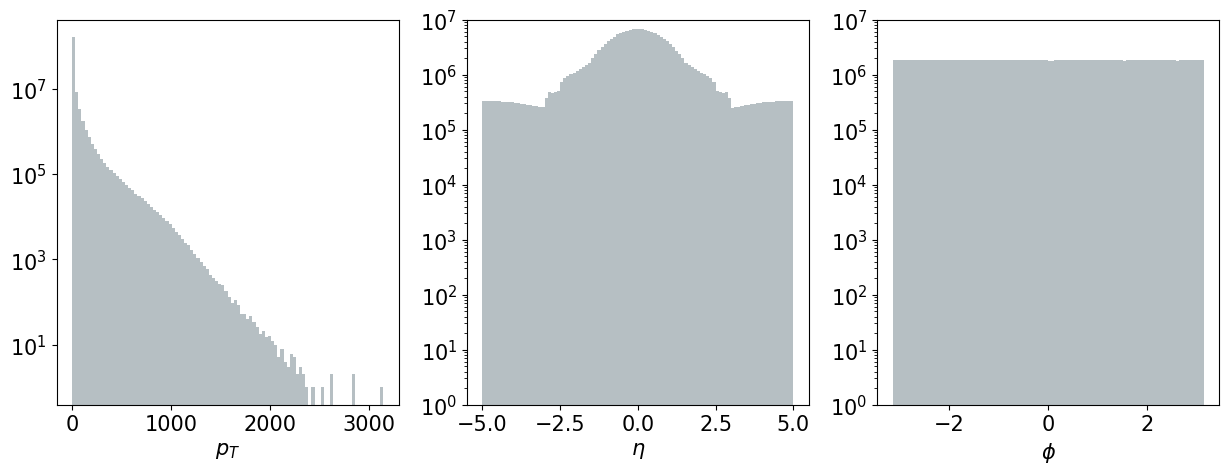

In [17]:
label_map = {"0": "$p_T$", "1": "$\eta$", "2": "$\phi$"}
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for index,ax in enumerate(axs):
    ax.hist(
        qcd_data[:, :, index].flatten()[qcd_data[:, :, index].flatten() != 0], bins=100
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.set_yscale("log")
    if index == 1:
        ax.set_ylim(1,)
    if index ==2 or index == 1:
        ax.set_ylim(1,1e7)
plt.show()

We define a function that clusters the given constituents into jets. The [Anti-$k_t$ algorithm](https://arxiv.org/abs/0802.1189) with $R=1.0$ is used to do so. Only the first two leading $p_T$ jets are returned.

In [8]:
jetdef = fj.JetDefinition(fj.antikt_algorithm, 1.0)

Awkward arrays are like numpy arrays, but they can have jagged dimensions. This is useful for particle physics, where we have a variable number of particles in each event. To benefit from the speed of awkward, we need to transform our data into an awkward array. For this, we first remove the zero padding and then tell the awkward array that our input data is a 4vector with eta, phi, pt, and mass.

In [9]:
# to awkard array
zrs = np.zeros((data_full.shape[0], data_full.shape[1], 1))
data_with_mass = np.concatenate((data_full, zrs), axis=2)
awkward_data = ak.from_numpy(data_with_mass)

In [10]:
# tell awkward that the data is in eta, phi, pt, mass format
vector.register_awkward()
unmasked_data = ak.zip({"pt": awkward_data[:,:,0], "eta": awkward_data[:,:,1], "phi": awkward_data[:,:,2], "mass": awkward_data[:,:,3]}, with_name="Momentum4D")
print(unmasked_data.type)

1100000 * 700 * Momentum4D[pt: float64, eta: float64, phi: float64, mass: float64]


In [11]:
#remove the padded data points
data = ak.drop_none(ak.mask(unmasked_data, unmasked_data.pt != 0))
print(data.type)

1100000 * var * Momentum4D[pt: float64, eta: float64, phi: float64, mass: float64]


Now the data can be clustered

In [12]:
cluster = fj.ClusterSequence(data, jetdef)

#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


In [13]:
# get jets and constituents
jets_out = cluster.inclusive_jets()
consts_out = cluster.constituents()

In [14]:
# define a function to sort ak.Array by pt
def sort_by_pt(data: ak.Array, ascending: bool = False, return_indices: bool = False):
    """Sort ak.Array by pt

    Args:
        data (ak.Array): array that should be sorted by pt. It should have a pt attribute.
        ascending (bool, optional): If True, the first value in each sorted group will be smallest; if False, the order is from largest to smallest. Defaults to False.
        return_indices (bool, optional): If True, the indices of the sorted array are returned. Defaults to False.

    Returns:
        ak.Array: sorted array
        ak.Array (optional): indices of the sorted array
    """
    if isinstance(data, ak.Array):
        try:
            temppt = data.pt
        except AttributeError:
            raise AttributeError(
                "Needs either correct coordinates or embedded vector backend"
            ) from None
    tmpsort = ak.argsort(temppt, axis=-1, ascending=ascending)
    if return_indices:
        return data[tmpsort], tmpsort
    else:   
        return data[tmpsort]

In [15]:
# sort jets and constituents by pt
jets_sorted, idxs = sort_by_pt(jets_out, return_indices=True)
consts_sorted_jets = consts_out[idxs]
consts_sorted = sort_by_pt(consts_sorted_jets)

In [25]:
# only take the first 2 highest pt jets
jets_awk = jets_sorted[:,:2]
consts_awk = consts_sorted[:,:2]

In [28]:
# max number of constituents in an event
max_consts = int(ak.max(ak.num(consts_awk, axis=-1)))
print(max_consts)

279


In [29]:
# Pad the data with zeros to make them all the same length
zero_padding = ak.zip({"pt": 0.0, "eta": 0.0, "phi": 0.0, "mass": 0.0}, with_name="Momentum4D")
padded_consts = ak.fill_none(ak.pad_none(consts_awk, max_consts, clip=True, axis=-1), zero_padding, axis=-1 )
print(padded_consts.type)

1100000 * var * 279 * Momentum4D[pt: float64, eta: float64, phi: float64, mass: float64]


In [30]:
# go back to numpy arrays
pt, eta, phi, mass = ak.unzip(padded_consts)
pt_np = ak.to_numpy(pt)
eta_np = ak.to_numpy(eta)
phi_np = ak.to_numpy(phi)
consts = np.stack((pt_np, eta_np, phi_np),axis=-1)
print(consts.shape)

(1100000, 2, 279, 3)


In [31]:
mask = np.expand_dims((consts[...,0] > 0).astype(int), axis=-1)
print(mask.shape)

(1100000, 2, 279, 1)


In [32]:
jets_pt_np = ak.to_numpy(jets_awk.pt)
jets_eta_np = ak.to_numpy(jets_awk.eta)
jets_phi_np = ak.to_numpy(jets_awk.phi)
jets_m_np = ak.to_numpy(jets_awk.m)
jets = np.stack((jets_pt_np, jets_eta_np, jets_phi_np, jets_m_np), axis=-1)
print(jets.shape)

(1100000, 2, 4)


split into signal and background

In [39]:
jets_background = jets[:len_bckg]
jets_signal = jets[len_bckg:]
mask_background = mask[:len_bckg]
mask_signal = mask[len_bckg:]
consts_background = consts[:len_bckg]
consts_signal = consts[len_bckg:]

## Save data

In [40]:
final_path = "/beegfs/desy/user/ewencedr/data/lhco/final_data/"

In [43]:
background_path = final_path + "processed_data_background.h5"
signal_path = final_path + "processed_data_signal.h5"
with h5py.File(background_path, "w") as f:
    f.create_dataset("jet_data", data=jets_background)
    f.create_dataset("constituents", data=consts_background)  
    f.create_dataset("mask", data=mask_background)  
with h5py.File(signal_path, "w") as f:
    f.create_dataset("jet_data", data=jets_signal)
    f.create_dataset("constituents", data=consts_signal)  
    f.create_dataset("mask", data=mask_signal)  

# Compare to provided features

In [132]:
label_map = {"0": "$p_T$", "1": "$\eta$", "2": "$\phi$", "3": "$m$"}

## Constituent Features

In [48]:
x_background = consts_background[:,0]
y_background = consts_background[:,1]
x_signal = consts_signal[:,0]
y_signal = consts_signal[:,1]
print(x_background.shape)

(1000000, 279, 3)


### Background

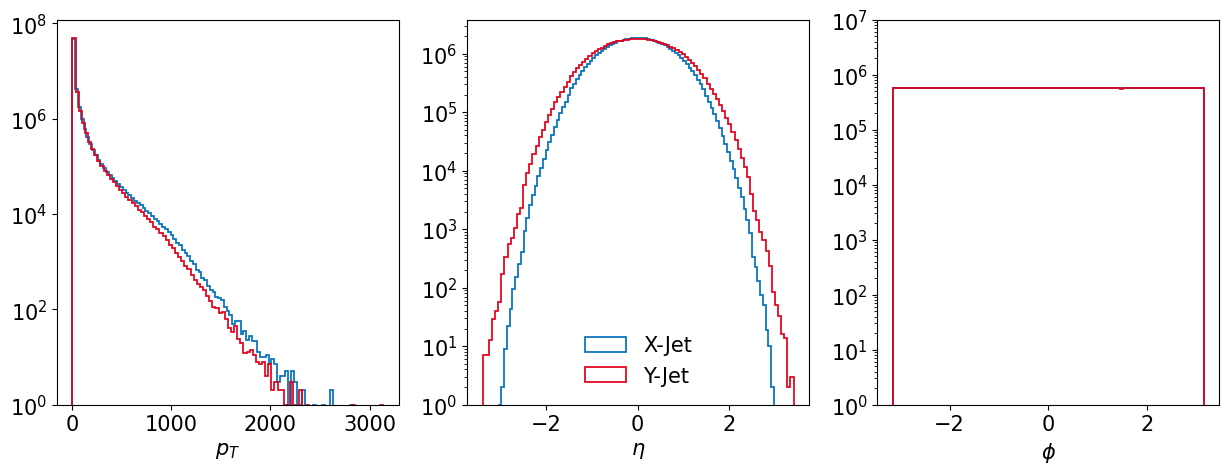

In [133]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for index,ax in enumerate(axs):
    # cycle through the colors
    next(ax._get_lines.prop_cycler)
    next(ax._get_lines.prop_cycler)
    
    ax.hist(
        x_background[:, :, index].flatten()[x_background[:, :, index].flatten() != 0], bins=100, label="X-Jet", histtype="step"
    )
    ax.hist(
        y_background[:, :, index].flatten()[y_background[:, :, index].flatten() != 0], bins=100, label="Y-Jet", histtype="step"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    if index == 0 or index == 1 or index == 2:
        ax.set_yscale("log")
    ax.set_ylim(1,)
    if index ==2:
        ax.set_ylim(1,1e7)
    if index == 1:
        ax.legend(frameon=False)
plt.show()

### Signal

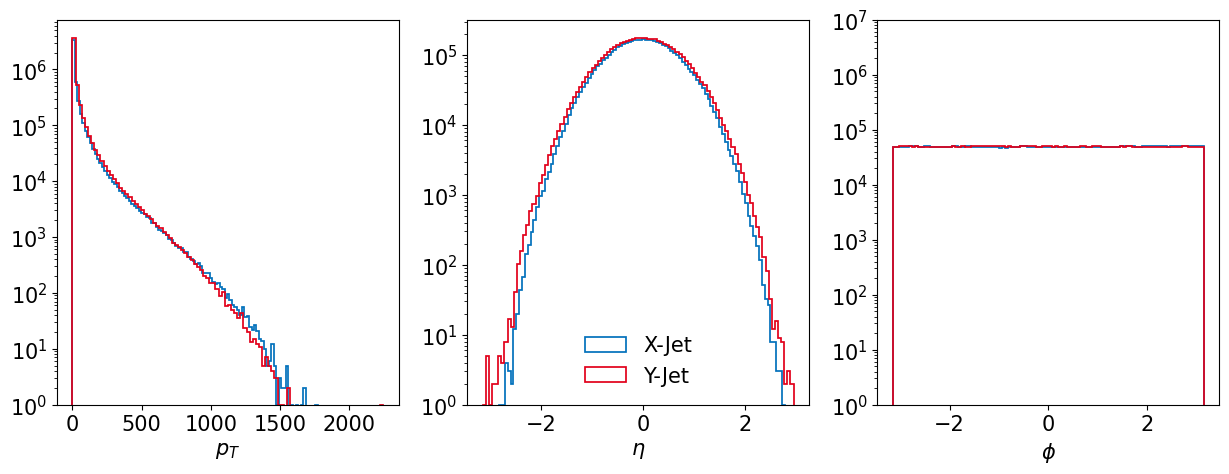

In [134]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for index,ax in enumerate(axs):
    # cycle through the colors
    next(ax._get_lines.prop_cycler)
    next(ax._get_lines.prop_cycler)
    
    ax.hist(
        x_signal[:, :, index].flatten()[x_signal[:, :, index].flatten() != 0], bins=100, label="X-Jet", histtype="step"
    )
    ax.hist(
        y_signal[:, :, index].flatten()[y_signal[:, :, index].flatten() != 0], bins=100, label="Y-Jet", histtype="step"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    if index == 0 or index == 1 or index == 2:
        ax.set_yscale("log")
    ax.set_ylim(1,)
    if index ==2:
        ax.set_ylim(1,1e7)
    if index == 1:
        ax.legend(frameon=False)
plt.show()

## Jet Features

### Load and prepare provided features

In [57]:
path_features = "/beegfs/desy/user/ewencedr/data/lhco/events_anomalydetection_v2.features.h5"

In [56]:
df = pd.read_hdf(path_features)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3))


(1100000, 15)
Memory in GB: 0.13113021850585938


In [66]:
feats = np.array(df)
background_feats = feats[feats[...,-1]==0][:,:-1]
signal_feats = feats[feats[...,-1]==1][:,:-1]
print(background_feats.shape)
print(signal_feats.shape)

(1000000, 14)
(100000, 14)


In [72]:
def to_ptyphim(feats):
    """  px, py, pz, mj --> pt, eta, phi, mj"""
    p3 = feats[:, :3]
    e = np.sqrt(feats[:, 0]**2 + feats[:, 1]**2 + feats[:, 2]**2 + feats[:, 3]**2)
    p4 = np.concatenate((e[:, None],p3), axis=1)
    ptyphim = ef.ptyphims_from_p4s(p4, phi_ref=0)
    return ptyphim

In [76]:
feats_x_background = to_ptyphim(background_feats[:,:4])
feats_y_background = to_ptyphim(background_feats[:,7:11])
feats_x_signal = to_ptyphim(signal_feats[:,:4]) 
feats_y_signal = to_ptyphim(signal_feats[:,7:11])

### Prepare fastjet data

In [77]:
jets_x_background = jets_background[:,0]
jets_y_background = jets_background[:,1]
jets_x_signal = jets_signal[:,0]
jets_y_signal = jets_signal[:,1]

### Background

#### X-Jet

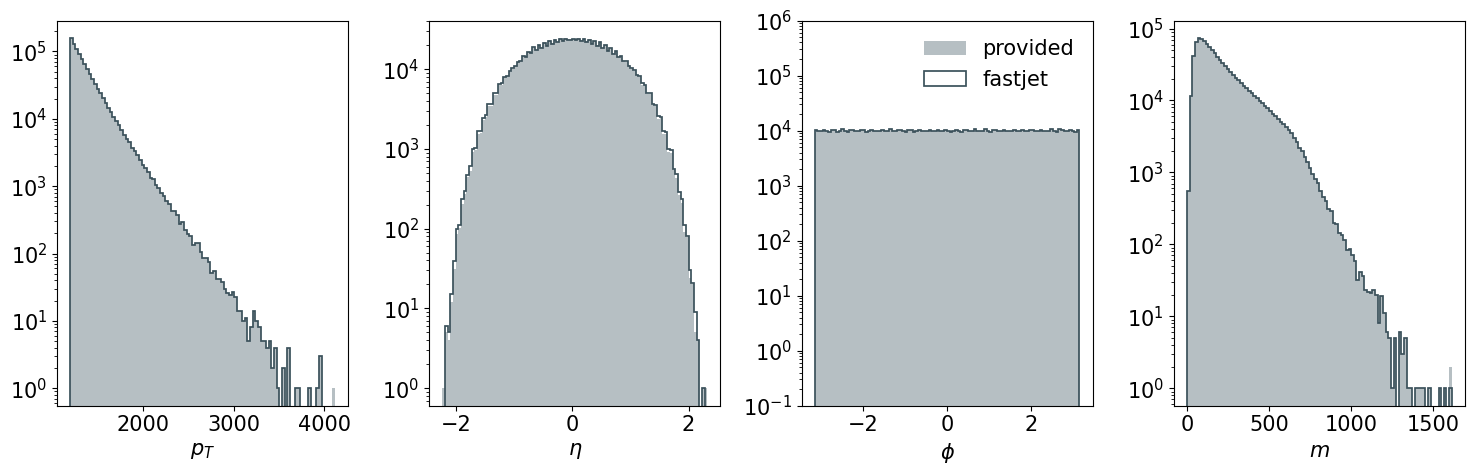

In [135]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    hist1 = ax.hist(
        feats_x_background[:, index], bins=100, label="provided"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.hist(jets_x_background[:,index],bins=hist1[1], histtype='step', label="fastjet")
    ax.set_yscale("log")
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e6)
plt.tight_layout()
plt.show()

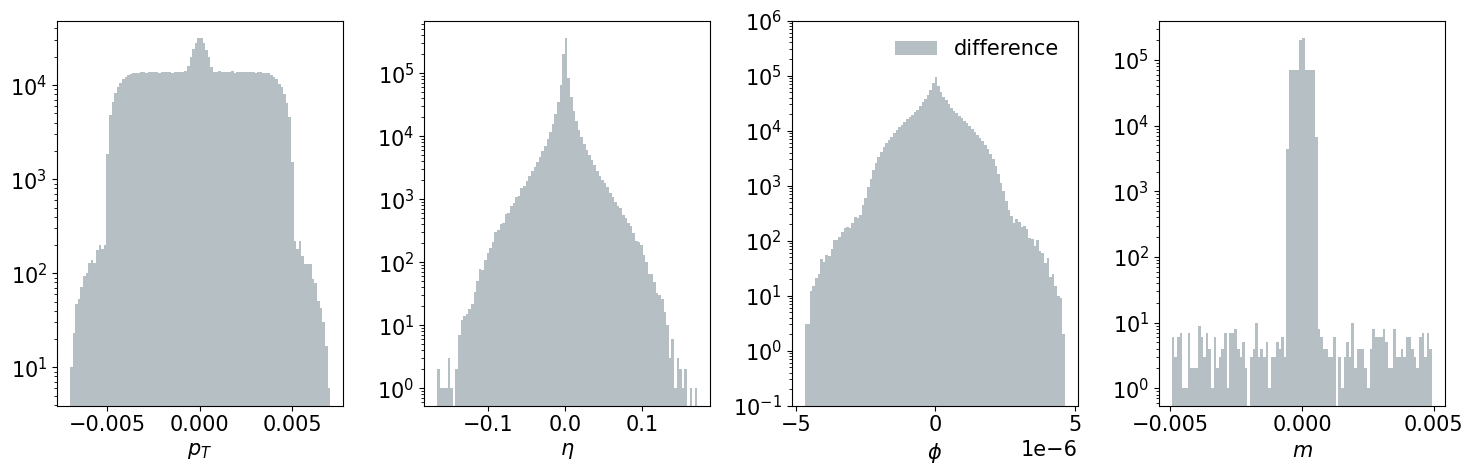

In [136]:
diff_background_x = feats_x_background - jets_x_background
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    hist1 = ax.hist(
        diff_background_x[:, index], bins=100, label="difference"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.set_yscale("log")
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e6)
plt.tight_layout()
plt.show()

#### Y-Jet

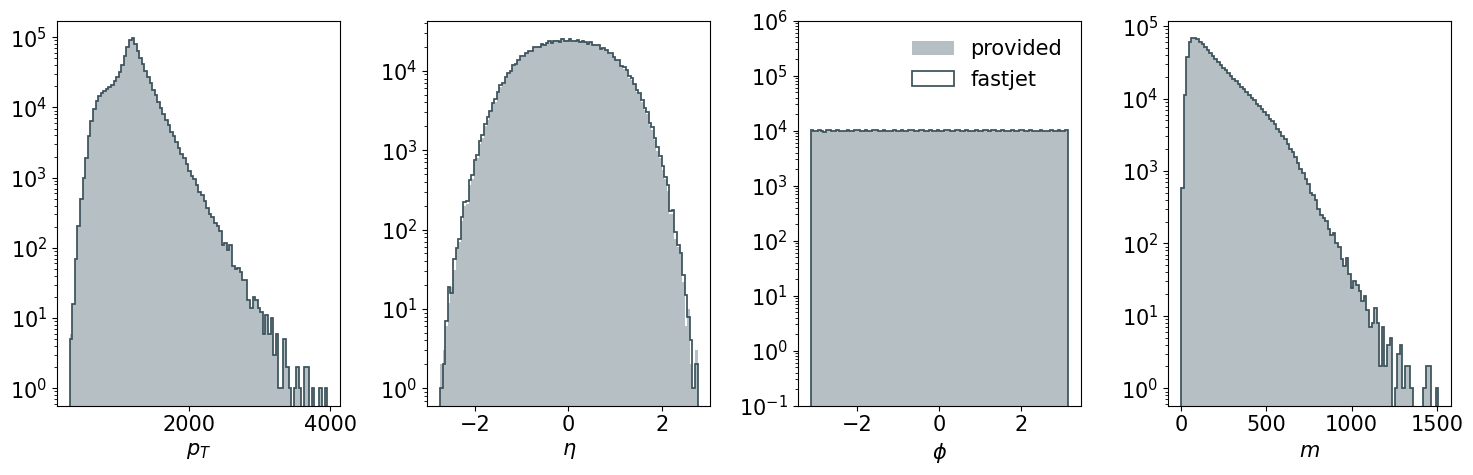

In [138]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    hist1 = ax.hist(
        feats_y_background[:, index], bins=100, label="provided"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.hist(jets_y_background[:,index],bins=hist1[1], histtype='step', label="fastjet")
    ax.set_yscale("log")
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1,1e6)
plt.tight_layout()
plt.show()

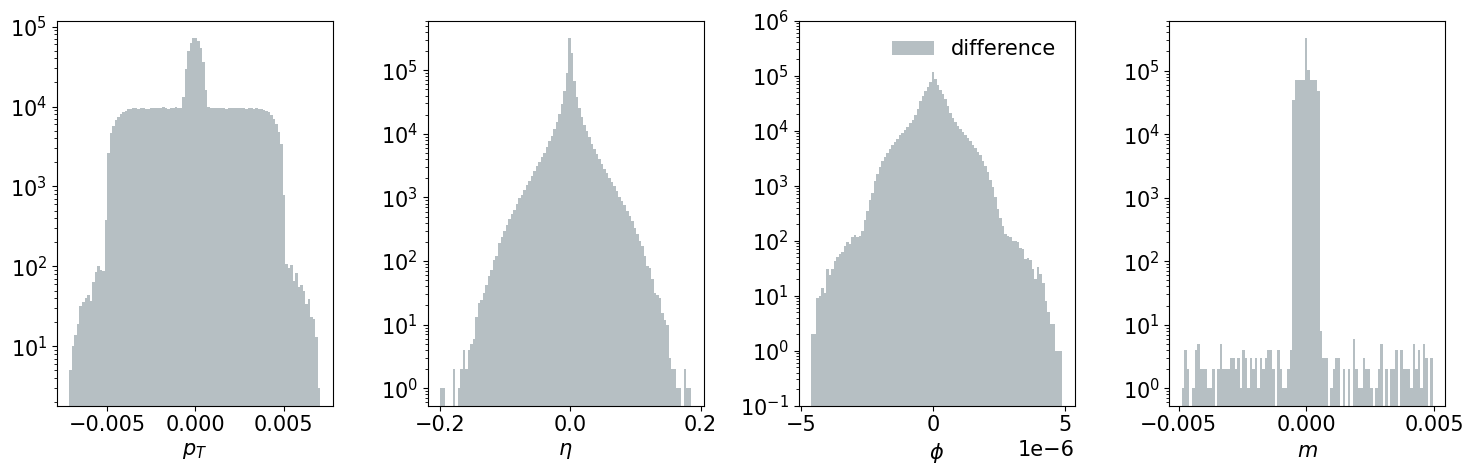

In [139]:
diff_background_y = feats_y_background - jets_y_background
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    hist1 = ax.hist(
        diff_background_y[:, index], bins=100, label="difference"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.set_yscale("log")
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e6)
plt.tight_layout()
plt.show()

### Signal

#### X-Jet

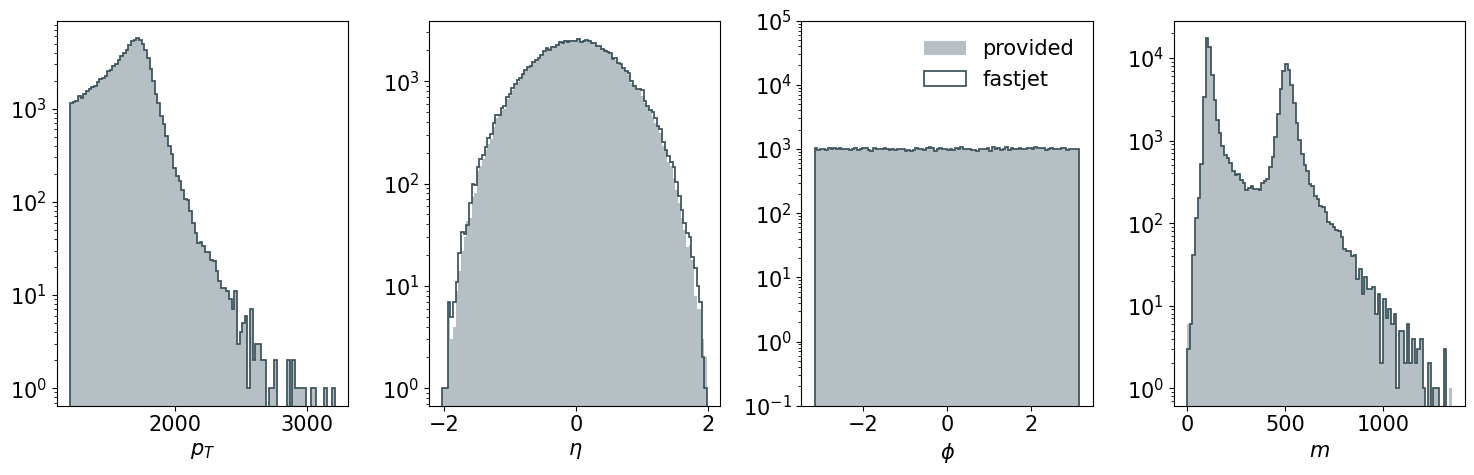

In [140]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    hist1 = ax.hist(
        feats_x_signal[:, index], bins=100, label="provided"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.hist(jets_x_signal[:,index],bins=hist1[1], histtype='step', label="fastjet")
    ax.set_yscale("log")
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e5)
plt.tight_layout()
plt.show()

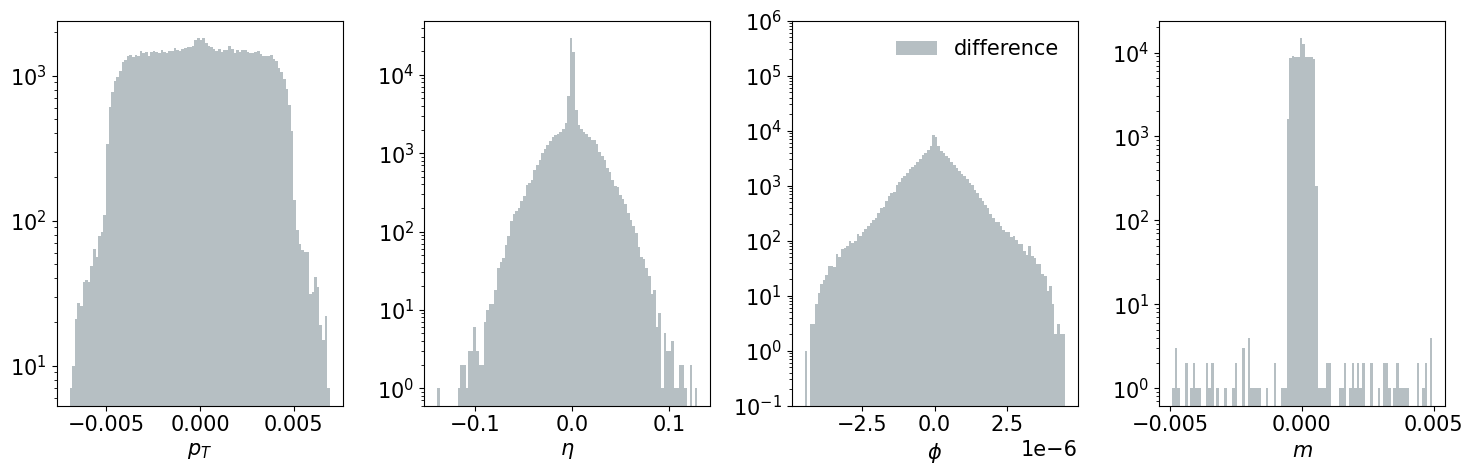

In [141]:
diff_signal_x = feats_x_signal - jets_x_signal
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    hist1 = ax.hist(
        diff_signal_x[:, index], bins=100, label="difference"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.set_yscale("log")
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e6)
plt.tight_layout()
plt.show()

#### Y-Jets

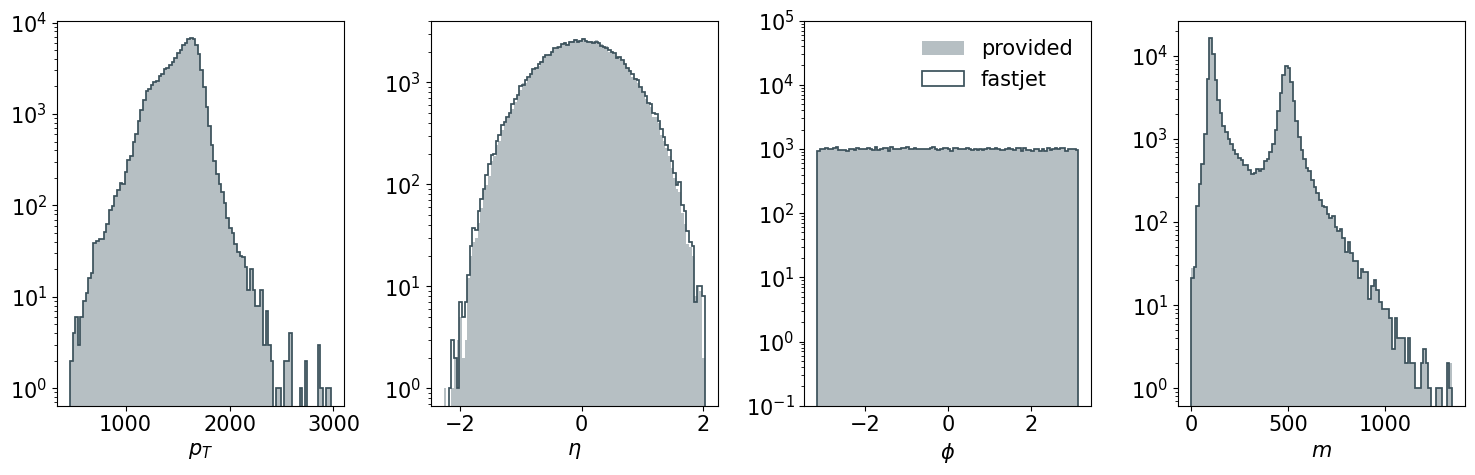

In [142]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    hist1 = ax.hist(
        feats_y_signal[:, index], bins=100, label="provided"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.hist(jets_y_signal[:,index],bins=hist1[1], histtype='step', label="fastjet")
    ax.set_yscale("log")
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e5)
plt.tight_layout()
plt.show()

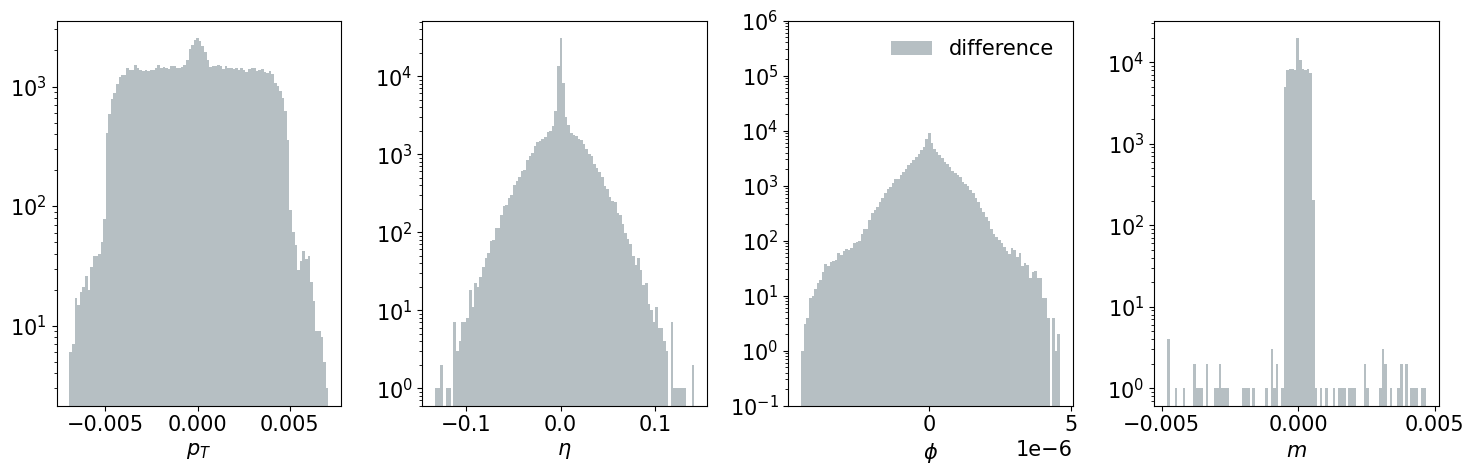

In [143]:
diff_signal_y = feats_y_signal - jets_y_signal
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for index,ax in enumerate(axs):
    hist1 = ax.hist(
        diff_signal_y[:, index], bins=100, label="difference"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.set_yscale("log")
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e6)
plt.tight_layout()
plt.show()